In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn.cluster import KMeans


from numpy.random import RandomState

rs = RandomState(12345)



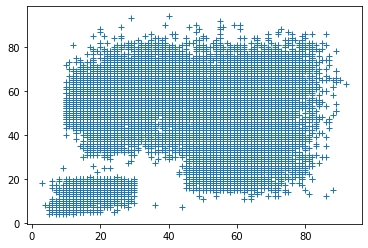

,mentality_interceptions,power_long_shots
16684,55,40
2104,72,54
6029,23,65
12544,60,30
8591,66,33
...,...,...
16930,54,21
4094,42,67
11689,59,34
2177,71,42


In [10]:
# import data
raw_df = pd.read_csv('./fifa_20.csv')
raw_df = raw_df[['mentality_interceptions','power_long_shots']]
plt.plot(raw_df['mentality_interceptions'], raw_df['power_long_shots'], '+')
plt.show()

test_df = raw_df.copy()

split_ratio = 0.7

# create split for training and testing
[training_data, test_data] = sklearn.model_selection.train_test_split(raw_df
                                                                    , test_size= 1 - split_ratio
                                                                    , train_size=split_ratio
                                                                    , random_state=rs
                                                                    , shuffle=True
                                                                    , stratify=None)

display(training_data)


In this week's exercise we explore the clustering method k-Means. First, the simplicity of implementing k-Means is shown, then different initialization techniques are compared.

## 1 The k-Means algorithm

Implement the two parts of the algorithm: cluster assignment and mean calculation.

**\_update\_clusters**
- As parameters, the function gets a DataFrame ($n \times d$) containing the dataset ($n$ samples with $d$ dimensions), and a DataFrame ($k \times d$) containing the $k$ mean vectors
- It returns an array of length $n$, containing a cluster label for each sample (row) of the data set 
\n e.g. looks like the following 
-> [0,1,5,3,5,3,2,3,4,9]

**\_update\_means**
- This function gets the DataFrame ($n \times d$) containing the dataset as well as an array of length $n$ containing the cluster label of each sample as parameters
- It returns a DataFrame of size $k \times d$ with the $k$ updated mean vectors 


<br>
Some Hints:
<ul>
<li><a href=https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.spatial.distance.cdist.html>scipy.spatial.distance.cdist</a></li>
<li><a href=https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html>numpy.argmin</a></li>
<li><a href=https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html>pandas.DataFrame.groupby</a></li>
</ul>

Feel free to add import statements! 

In [11]:
# Implement _update_clusters and _update_means


def myKMeans(df, k, iterations):
    data = df.copy()
    feature_names = data.columns
    means = _init_means(data, k, feature_names)
    clusters = _update_clusters(data, means)
    
    for i in range(iterations):
        means = _update_means(data, clusters)
        clusters = _update_clusters(data, means)
    return clusters

def _init_means(data, k, feature_names):
    data = data[feature_names]
    min_values = data.min()
    max_values = data.max()

    # get random samples
    means = np.random.uniform(min_values, max_values, (k, data.shape[1]))
    means = pd.DataFrame(data = means, columns=feature_names)
    means.index.name = 'cluster'
    return means


def _update_clusters(data, means):

    """    
    Implement _update_clusters
    assign all the values to their nearest cluster center (mean)
    this functions returns a list with cluster labels for each datapoint,
    for performance reason a numpy array is used
    calculate euclidean distance for all datapoints and clusters
    the column represents the corresponding cluster
    the rows represents the datapoints
    """

    dist = scipy.spatial.distance.cdist(  XA = data.values
                                        , XB = means.values
                                        , metric='euclidean')
                                 
    # choose smallest distance in every row vector i. e. the cluster index
    clusters = np.apply_along_axis(func1d = np.argmin
                                 , axis = 1
                                 , arr = dist)
    return clusters

def _update_means(data, clusters):
    # Implement _update_means
    means = data.copy()
    means['cluster'] = clusters
        # groupby assigned cluster labels and calculate the mean for each group
    means = means.groupby('cluster').mean()
    
    return means

Test your implementation by clustering the features ``mentality_interceptions`` and ``power_long_shots``. <br>
Try different values for $k$ and visualize the results. Which $k$ seems to produce the best result?  
Also calculate the [Silhouette Coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Does it confirm your intuition?

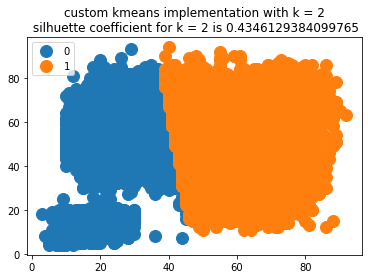

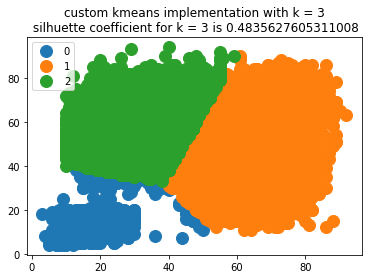

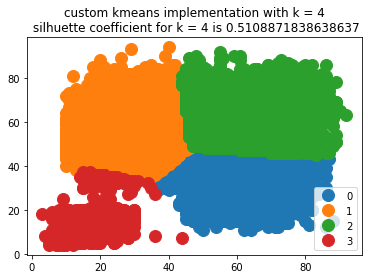

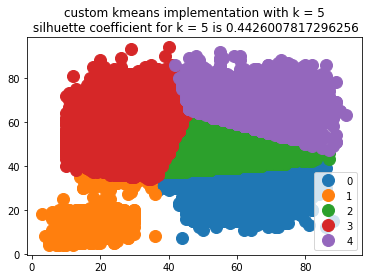

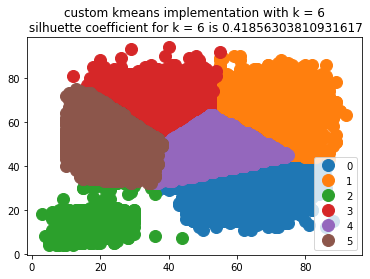

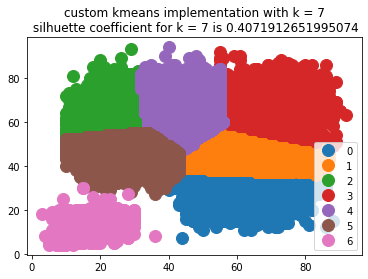

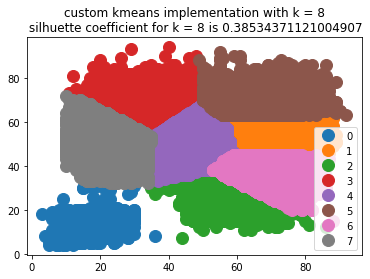

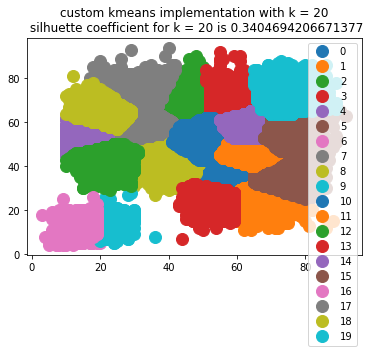

In [5]:
# Use your k-Means implementation and visualize the results. Print the silhouette score.

for i in [2,3,4,5,6,7,8,20]:
    clusters = []
    clusters = myKMeans(df = test_df, k = i , iterations = 20)
    output_df = test_df.copy()
    output_df['cluster'] = clusters
    groups = output_df.groupby('cluster')
    plt.figure()
    # plot all different clusters
    for name, group in groups:       
        plt.plot( group.iloc[:,0]
                , group.iloc[:,1]
                , marker='o'
                , linestyle=''
                , markersize=12
                , label=name)

    s = sklearn.metrics.silhouette_score(test_df, labels = clusters, metric='euclidean', random_state=rs)
    print()
    plt.title("custom kmeans implementation with k = " + str(i) + "\n " + 'silhuette coefficient for k = ' + str(i) + ' is ' + str(s))
    plt.legend()
    plt.show()

### It seems that for k = 3, the most inutitive partition or clustering is found.
### But when regarding the siluette coefficient the best result is the closest to +1. In this case, the best result would be for k = 4.

## 2 Different initializations of k-Means

Take a look at the influence of different initializations of the k-Means algorithm. For this purpose, compare random initialization with the [*k-means++* initialization algorithm](https://en.wikipedia.org/wiki/K-means%2B%2B). Use the [sklearn implementation of k-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and run the algorithm with: 
- `1, 2, 3, 4, 5, 10, 20` as the maximum number of iterations (`max_iter`)
- `10` initializations each (`n_init`)
- and a convergence tolerance of `0` (`tol`).

For both initialization methods, plot the final value of the objective function (`inertia_`) against the number of iterations in line plots of different colors.

What do you observe?

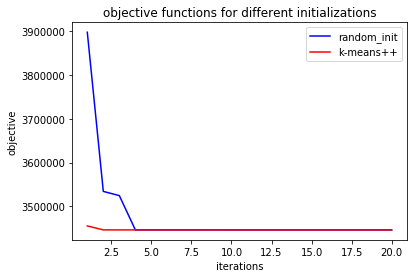

In [13]:
# Use the sklearn implementation of k-Means and plot the objective function for both initialization methods.

# number of clusters
k = 3

iterations = [1, 2, 3, 4, 5, 10, 20]

objective = pd.Series(data=0, index=iterations)
objective_pp = pd.Series(data=0, index=iterations)

for i in iterations:

    # with 'k-means++'
    kmeans = KMeans(
                  n_clusters=k
                , init='k-means++'
                , n_init=10
                , max_iter=i
                , tol=0
                , verbose=0
                , random_state=None
                , copy_x=True
                , algorithm='auto')

    kmeans.fit(training_data)
    objective_pp[i] = kmeans.inertia_

        # with random init
    kmeans = KMeans(
                  n_clusters=k
                , init='random'
                , n_init=10
                , max_iter=i
                , tol=0
                , verbose=0
                , random_state=None
                , copy_x=True
                , algorithm='auto')

    kmeans.fit(training_data)
    objective[i] = kmeans.inertia_

    
    

plt.plot(objective.index, objective, 'b-')
plt.plot(objective_pp.index, objective_pp, 'r-')
plt.title('objective functions for different initializations')
plt.xlabel('iterations')
plt.ylabel('objective')
plt.legend(['random_init','k-means++'])
plt.show()

The k-means++ algorithm starts with a smaller objective right after one iteration than the random init. Also the k-means++ converges after less iterations to a stationary solution. 
For the random initialization, the objetive function does not decrease strong monotnously, but there is a local maximum in the objective function. That is flattended with increasing k.
In the end, both inits get to the same result, however k-means++ is more efficient.

### Test and predict model

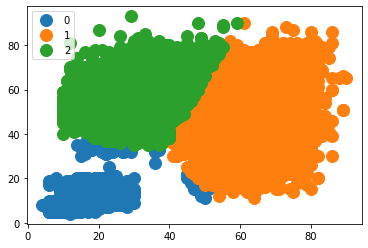

In [7]:
test_df = test_data.copy()

cluster = kmeans.predict(test_data)
#plt.scatter(test_data.iloc[:,0], test_data.iloc[:,1], c = cluster, cmap = 'Greens')
test_df['cluster'] = cluster
groups = test_df.groupby('cluster')

for name, group in groups:
    plt.plot(group.iloc[:,0], group.iloc[:,1], marker='o', linestyle='', markersize=12, label=name)

plt.legend()

does not quite look like the expected clustering result.